# LDA

In [1]:
import pandas as pd
import numpy as np
from numba import jit

import matplotlib.pyplot as plt
plt.style.use("ggplot")

import seaborn as sns
diverging_cmap = 'seismic'
# diverging_palette = sns.color_palette(diverging_cmap, 35+6)[5:-1] # 
diverging_palette = sns.color_palette(diverging_cmap, 35)

from collections import Counter

In [2]:
# ordered tonal pitch classes
dia = list("FCGDAEB")
accs = ["bb", "b", "", "#", "##"]
lof = [ d + a for a in accs for d in dia ]

## Running example

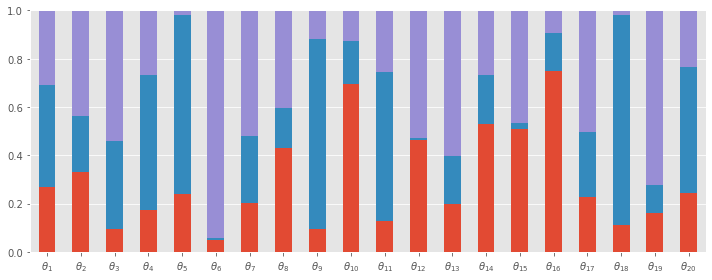

In [19]:
seed = np.random.seed(0)

# constants
K = 3 # np.random.randint(2,9)
D=20
V=35

alpha = [1]*K # uniform 
theta = pd.DataFrame(np.random.dirichlet(alpha=alpha, size=D))
theta.plot(
    kind='bar', 
    rot=0, 
    stacked=True,
    figsize=(10,4)
)
plt.xticks(np.arange(D), [f"$\\theta_{{{i}}}$" for i in np.arange(D)+1])
plt.legend().remove()
plt.margins(0,0)
plt.tight_layout()
# plt.savefig("img/random_topic_probs.pdf");

In [7]:
theta.iloc[14,:].round(3)

0    0.507
1    0.026
2    0.466
Name: 14, dtype: float64

In [8]:
# create artificial random pitch-class distributions ("topics")
seed = np.random.seed(0)
pc_dists = []

for k in range(K):
    pc_dist = np.random.dirichlet([1]*V)
    pc_dists.append(pc_dist)

beta = np.column_stack(pc_dists)

In [9]:
Beta = pd.DataFrame(beta)
Beta.index = lof
# Beta
# Beta.index = lof # list(note2lof.keys())
# Beta = Beta.reindex(lof[0])
Beta.index = [s.replace("#", "$\\sharp$").replace("x", "$\\sharp\\sharp$").replace("b", "$\\flat$") for s in lof]
Beta = Beta[[2,1,0]] # reorder for plotting

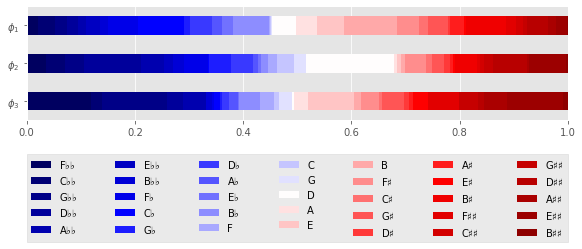

In [11]:
seed = np.random.seed(0)
Beta.T.plot.barh(
    figsize=(8,4), 
    rot=0, 
    color=diverging_palette,
    stacked=True
)
# plt.title(f'Distribution of {V} tonal pitch classes in {K} topics')
plt.legend()
# plt.ylabel('tpc distribution')
plt.legend(bbox_to_anchor=(0, -0.4, 1., .102),
       ncol=7, mode="expand", borderaxespad=0., fancybox=False)
plt.tight_layout()
plt.margins(0,0)
plt.yticks(np.arange(K), [f"$\phi_{k}$" for k in np.flip(np.arange(K))+1])
# plt.savefig("img/random_tpcs_in_topics.pdf")
plt.show()

In [12]:
Beta.loc["F":"G", :]

,2,1,0
F,0.026552,0.016642,0.001863
C,0.009794,0.031084,0.002305
G,0.023524,0.021251,0.000516


In [13]:

def create_fake_corpus(D):
    corpus = []

    for d in range(D):
        piece = []

        # number of notes in piece
        L = np.random.poisson(lam=100) # on average 100 notes per piece

        # choose topic for each note
        topic_list = []

        for l in range(L):
            z = np.random.multinomial(1, theta.iloc[d,:].values).nonzero() # draw topic number for note
            topic_list.append(z[0][0])

        for topic in topic_list:
            note = np.random.multinomial(1,beta[:,topic]).nonzero()[0][0]
            piece.append(note)
        corpus.append(piece)
        
    return corpus

In [14]:
fake_corpus = create_fake_corpus(D)

In [15]:
piece_tpc_counts = pd.DataFrame(0, index=range(D), columns=lof)

for i, piece in enumerate(fake_corpus):
    for note in piece:
        piece_tpc_counts.iloc[i, note] += 1
            
piece_tpc_counts

,Fbb,Cbb,Gbb,Dbb,Abb,Ebb,Bbb,Fb,Cb,Gb,...,A#,E#,B#,F##,C##,G##,D##,A##,E##,B##
0,10,3,7,4,5,1,3,2,0,1,...,0,1,3,2,0,4,2,1,2,1
1,5,0,3,7,4,0,1,6,6,1,...,2,2,4,2,2,0,6,2,5,0
2,5,5,2,5,5,2,1,1,3,3,...,1,0,4,7,2,4,5,4,9,2
3,6,3,7,5,4,2,1,2,2,2,...,0,1,4,1,0,0,4,1,8,2
4,2,3,3,9,0,0,2,5,4,1,...,1,1,2,0,1,0,5,0,5,0
5,7,1,10,2,4,0,2,2,0,0,...,2,4,0,8,0,3,3,5,8,0
6,10,1,8,4,1,1,5,0,2,2,...,0,3,1,2,1,0,2,1,8,0
7,7,3,12,2,0,0,1,2,5,0,...,1,0,4,4,0,2,7,1,6,1
8,3,4,5,7,5,1,0,7,0,3,...,1,0,0,0,1,4,6,0,3,0
9,4,4,2,4,3,3,3,5,4,2,...,1,0,5,1,3,1,4,0,4,0


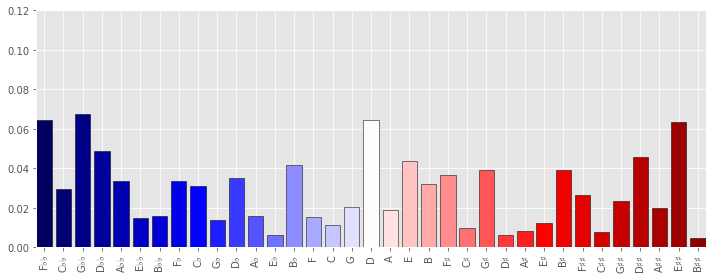

In [18]:
vals = piece_tpc_counts.sum(axis=0).div(piece_tpc_counts.sum().sum()).values
fig, ax = plt.subplots(figsize=(10,4))
plt.bar(
    np.arange(35),
    vals, 
    color=diverging_palette,
    edgecolor="k"
)
plt.xticks(np.arange(35),lof, rotation=90)
ax.set_xticklabels([s.get_text().replace("#", "$\\sharp$").replace("x", "$\\sharp\\sharp$").replace("b", "$\\flat$") for s in ax.get_xticklabels()])
plt.ylim(0,.12)
plt.margins(0,0)
plt.tight_layout()
# plt.savefig("img/random_tpc_dist.pdf");

In [13]:
piece_tpc_counts.columns = [s.replace("#", "$\\sharp$").replace("x", "$\\sharp\\sharp$").replace("b", "$\\flat$") for s in lof]

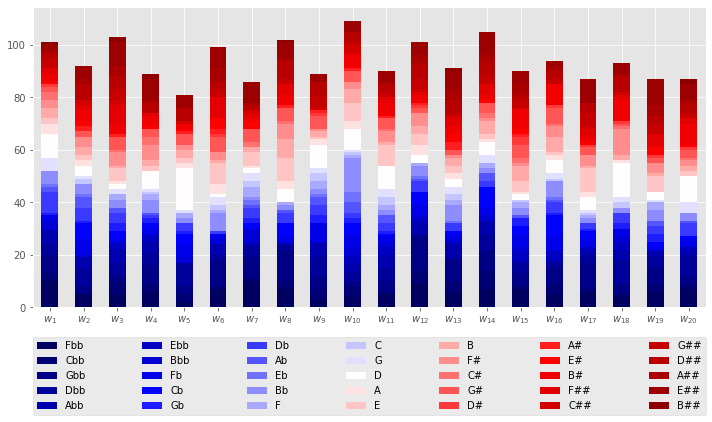

In [23]:
piece_tpc_counts.plot(
    kind='bar', 
    figsize=(10,6), 
    rot=0, 
    color=diverging_palette,
    stacked=True,
)
# plt.title(f'Distribution of {V} pitches in {D} documents (given {K} topics)')
# plt.legend(title='pitches')
# plt.ylabel('counts')
# plt.xlabel('documents');
plt.legend(bbox_to_anchor=(0, -0.2, 1., .102),
       ncol=7, mode="expand", borderaxespad=0.)
plt.xticks(np.arange(D), [f"$w_{{{i}}}$" for i in np.arange(D)+1])
plt.tight_layout()
# plt.savefig("img/random_document_tpc_dist.pdf");

This generative process defines a joint probability distribution over observed and latent random variables for each piece in the corpus:

$$ p(\theta, \mathbf z, s \mid \alpha, \beta) = p(\theta \mid \alpha)\prod_{n=1}^N p(z_n \mid \theta) \prod_{l=1}^L p(u_{nl} \mid z_n, \beta).$$

In this model, a piece is a bag-of-segments, and segments are bags-of-notes. 

## Real corpus

In [25]:
url = "https://raw.githubusercontent.com/DCMLab/TP3C/master/tp3c.tsv"
df = pd.read_csv(url, sep="\t")
counts = df.loc[:,"Fbb":"B##"]
counts.head()

,Fbb,Cbb,Gbb,Dbb,Abb,Ebb,Bbb,Fb,Cb,Gb,...,A#,E#,B#,F##,C##,G##,D##,A##,E##,B##
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,71,49,21,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,6,...,34,13,11,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,93,0,0,0,0,0,0,0,0,0


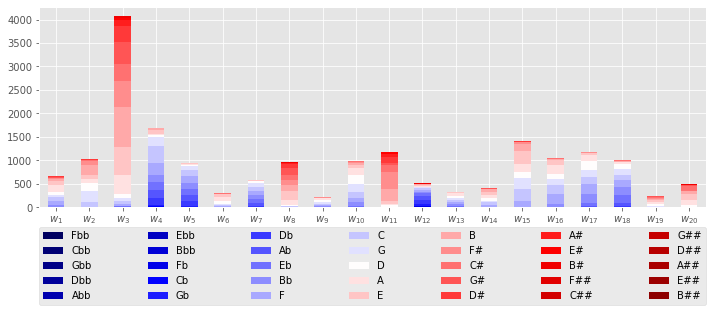

In [30]:
### TPC dist for randomly selected real pieces
# idx = only_counts.sample(20,random_state=9).index.sort_values()

counts.columns = piece_tpc_counts.columns

counts.sample(20, random_state=9).sort_index().plot(
    kind='bar', 
    figsize=(10,4.5), 
    rot=0, 
    color=diverging_palette,
    stacked=True,
)
plt.legend(bbox_to_anchor=(0, -0.2, 1., .102),
       ncol=7, mode="expand", borderaxespad=0.)
plt.xticks(np.arange(20), [f"$w_{{{i}}}$" for i in np.arange(20)+1])
plt.tight_layout()
# plt.savefig("img/random_real_document_tpc_dist.pdf");

## Inference via Gibbs Sampling

In [31]:
# Constants

K = 7
D = counts.shape[0]
notes = counts.sum().sum() # sum([len(piece) for piece in corpus])
distinct_notes = counts.columns #set(note for piece in corpus for note in piece)
V = len(distinct_notes) # vocabulary size

print(f'We have {K} topics, {D} documents, and {notes} notes ({V} distinct).')

We have 7 topics, 2012 documents, and 2707112 notes (35 distinct).


#### Define Data Structures

In [32]:
corpus =  [ ]

for _, piece in counts.iterrows():
    corpus.append([ k for k, v in piece.iteritems() for _ in range(v) ])

For each piece, we count how often each topic occurs. This can be expressed as a $D \times K$ matrix.

In [33]:
piece_topic_counts = [Counter() for _ in corpus]

For each topic, we count how often a note is associated with that topic. This can be expressed as a $K \times V$ matrix.

In [34]:
topic_note_counts = [Counter() for _ in range(K)]

Moreover, we note how often each topic occurs overall.

In [35]:
topic_counts = [0 for _ in range(K)]

Also how many notes we have per piece.

In [36]:
piece_lengths = [ len(piece) for piece in corpus]

The overall probability of topic $k$ given piece $d$ is defined as the fraction of notes in this document associated with that topic.

In [37]:
def p_topic_given_piece(topic, d, gamma=0.1):
    """the fraction of notes in piece _d_
    that are assigned to _topic_ (plus some smoothing)"""
    try:
        p_z_d = ((piece_topic_counts[d][topic] + gamma) /
                (piece_lengths[d] + K * gamma )) 
        return p_z_d
    except Exception as e:
        print(e, "p_topic_given_piece")

The probability of a note given topic $k$ is defined as the fraction of the frequency of that note in this topic and the overall frequency of this topic.

In [38]:
def p_note_given_topic(note, topic, delta=0.1):
    """the fraction of notes assigned to _topic_
    that equal _note_ (plus some smoothing)"""
    return ((topic_note_counts[topic][note] + delta) / 
            (topic_counts[topic] + V * delta))

The probability that a note in a document is associated with a certain topic is the product of the previous probabilities.

In [39]:
def sample_from(weights):
    """returns i with probability weights[i] / sum(weights),
    e.g. sample_from([20, 30, 50]) returns either 0 with probability 1/5, 1 with prob 3/10, or 2 with prob 1/2."""
    total = sum(weights)
    rnd = total * np.random.rand() # uniform between 0 and total
    for i, w in enumerate(weights):
        rnd -= w # return the smallest i such that
        if rnd <= 0: 
            return i # weights[0] + ... + weights[i] >= rnd

In [40]:
def topic_weight(d, note, k):
    """given a piece and a note in that piece,
    return the weight for the kth topic"""
    try:
        weight = p_note_given_topic(note, k) * p_topic_given_piece(k, d)
        return weight
    except Exception as e:
        print(e, "topic_weight")

def choose_new_topic(d, note):
    new_topic = sample_from([topic_weight(d, note, k) for k in range(K)])
    return new_topic


#### Initialization

In [41]:
# each note in a piece gets a randomly assigned topic
piece_topics = [[np.random.randint(K) for note in piece]
                   for piece in corpus]

In [42]:
# populate counters based on random topic assignment

for d in range(D):
    for note, topic in zip(corpus[d], piece_topics[d]):
        piece_topic_counts[d][topic] = piece_topic_counts[d][topic] + 1
        topic_note_counts[topic][note] = topic_note_counts[topic][note] + 1
#         topic_note_counts[topic][ note2idx(note) ] = topic_note_counts[topic][ note2idx(note) ] + 1
        topic_counts[topic] = topic_counts[topic] + 1

#### Iterate

In [43]:
def gibbs_sampling(iters=20):
    for j in range(iters):
        for d in range(D):
            for i, (note, topic) in enumerate(zip(corpus[d], piece_topics[d])):
                # remove this note / topic from the counts
                # so that it doesn't influence the weights
                piece_topic_counts[d][topic] = piece_topic_counts[d][topic] - 1
                topic_note_counts[topic][note] = topic_note_counts[topic][note] - 1
                topic_counts[topic] = topic_counts[topic] - 1
                piece_lengths[d] = piece_lengths[d] - 1

                # choose a new topic based on the weights
                new_topic = choose_new_topic(d, note)
                piece_topics[d][i] = new_topic
            
                # and now add it back to the counts
                piece_topic_counts[d][new_topic] = piece_topic_counts[d][new_topic] + 1
                topic_note_counts[new_topic][note] = topic_note_counts[new_topic][note] + 1
                topic_counts[new_topic] = topic_counts[new_topic] + 1
                piece_lengths[d] = piece_lengths[d] + 1

In [44]:
%%time
# takes ~15 mins for 50 iterations
gibbs_sampling(iters=100) # 200

CPU times: user 44min 52s, sys: 782 ms, total: 44min 53s
Wall time: 44min 55s


In [45]:
topic_list = []

idx = counts.columns

for k, note_counts in enumerate(topic_note_counts):
    s = pd.Series(index=idx,data=0) 
    for note, count in note_counts.most_common(): 
        if count > 0: 
            s[note] += count
    topic_list.append(s)

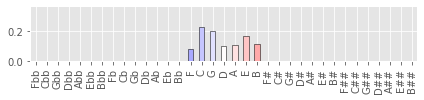

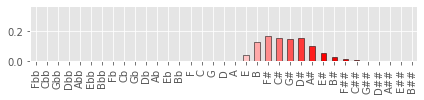

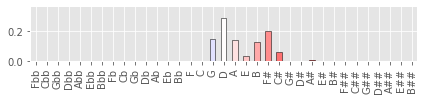

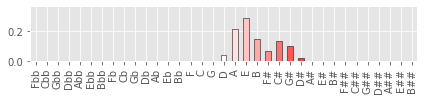

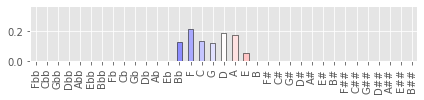

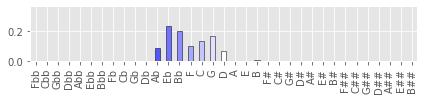

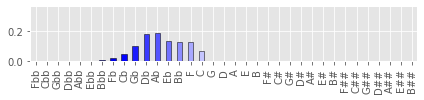

In [46]:
for k in range(K): 
    # normalize
    t = topic_list[k] / topic_list[k].sum()
    t.plot(
        kind='bar', 
        figsize=(6,1.5), 
        rot=90, 
        color=diverging_palette,
        edgecolor="k"
    )
    plt.ylim(0,.36)
    plt.tight_layout()
    plt.savefig(f'img/topic_7-{k+1}_new.png', dpi=300)
    plt.show()

In [47]:
topic_df = pd.DataFrame(topic_list).T

# normalize
topic_df = topic_df.div(topic_df.sum(axis=0), axis=1)
topic_df.columns = [f"$\phi_{k}$" for k in np.arange(1, K+1) ]
topic_df.index = lof
topic_df.index = topic_df.index.str.replace("b", "$\\flat$").str.replace("#", "$\\sharp$")
topic_df

,$\phi_1$,$\phi_2$,$\phi_3$,$\phi_4$,$\phi_5$,$\phi_6$,$\phi_7$
F$\flat$$\flat$,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
C$\flat$$\flat$,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000045
G$\flat$$\flat$,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000019
D$\flat$$\flat$,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000213
A$\flat$$\flat$,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000761
E$\flat$$\flat$,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002675
B$\flat$$\flat$,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007401
F$\flat$,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020546
C$\flat$,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045947
G$\flat$,0.000000,0.000000,0.000003,0.000000,0.000009,0.000000,0.100954


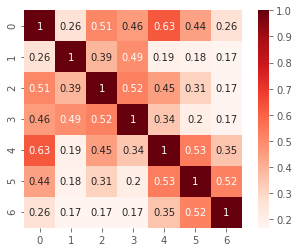

In [48]:
#%%
from scipy.spatial.distance import jensenshannon, pdist, squareform

M = squareform(
        pdist(
            topic_df.values.T, lambda p, q: 1 - jensenshannon(p, q)
            )
        ) + np.diag(np.ones(7))

sns.heatmap(M, square=True, annot=True, cmap="Reds")
plt.show()

# %%


In [69]:
topic_df.round(3).to_latex("tables/topic_tpcs_7.tex", escape=False)

### Importance of Topics in corpus

The relative weights of the topics in the overall corpus can be seen below. The most common topic is topic 0 ("(transposed) diatonic") and the least common is topic 4 ("far-flats")

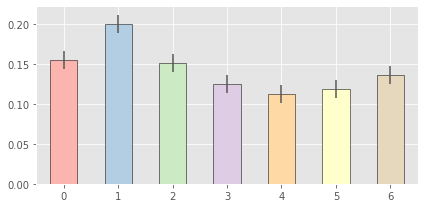

In [70]:
cs = sns.color_palette("Pastel1", 7)

topic_freqs = np.asarray(topic_counts) / sum(topic_counts)

pd.Series(topic_freqs).plot(
    kind='bar', 
    rot=0, 
    figsize=(6,3), 
    color=cs,
    edgecolor="k",
    yerr=np.std(topic_freqs, ddof=1) / np.sqrt(np.size(topic_freqs)) # standard error of the mean
)#, color=categorical_palette)
# H = entropy(topic_counts)
plt.tight_layout()
plt.savefig(f'img/{K}_topics_weights_new.png', dpi=300)
plt.show()

In [72]:
piece_topic_counts = pd.DataFrame(piece_topic_counts)
piece_topic_counts.tail(12)

,6,0,5,4,3,2,1
2000,431,0,0,355,636,0,37
2001,90,30,0,568,1366,221,143
2002,0,185,0,0,7,25,1
2003,91,0,41,70,0,558,392
2004,7,1026,85,5,74,0,467
2005,0,1166,35,31,33,0,471
2006,0,853,0,0,127,0,476
2007,0,102,1762,0,43,0,34
2008,782,0,4,1,454,544,0
2009,103,77,12,88,99,57,1061


In [73]:
# Alkan example idx 588
s = piece_topic_counts.iloc[588,:-1]
s /= s.sum()
s.sort_values(ascending=False).cumsum()

6    0.420326
0    0.625149
4    0.775314
5    0.889673
2    0.979167
3    1.000000
Name: 588, dtype: float64

In [74]:
# Bach Cmajor Prelude idx 168
s = piece_topic_counts.iloc[168,:-1]
s /= s.sum()
s.sort_values(ascending=False)

2    0.824926
0    0.103858
3    0.071217
6    0.000000
5    0.000000
4    0.000000
Name: 168, dtype: float64

All matrices were based on documents. In the classical LDA setting, a corpus is a bag of documents. 
We are in particular interested in historical developments, so the chronological order is important.
Moreover, we do not a piece for each year and for some years we have many pieces.
The first step is to re-assign each piece its "display_year" (composition, publication, of composer half-life).
Then we average all pieces in the same year.
We now have at most one topic distribution per year in the corpus.

But there are still years for which we do not have data, in particular in the earlier periods.
Pragmatically, if we do not have a topic distribution for a given year, we take the one from the previous year. 
To that end, we create a time index ranging from the earliest to the latest date in the corpus.

In [75]:
piece_topic_counts['year'] = df["display_year"]

piece_topic_counts_by_year = piece_topic_counts.groupby('year').sum()
piece_topic_counts_by_year.tail()

,6,0,5,4,3,2,1
year,,,,,,,
1921.0,1186,867,233,837,182,108,705
1923.0,14,783,289,2,16,214,117
1925.0,24,900,801,207,483,983,1017
1936.0,60,512,57,321,284,28,0
1942.0,489,1593,284,1146,794,275,1402


In [76]:
piece_topic_freqs = piece_topic_counts_by_year.div(piece_topic_counts_by_year.sum(axis=1), axis=0).fillna(0)
piece_topic_freqs.tail()

,6,0,5,4,3,2,1
year,,,,,,,
1921.0,0.288004,0.210539,0.056581,0.203254,0.044196,0.026226,0.171200
1923.0,0.009756,0.545645,0.201394,0.001394,0.011150,0.149129,0.081533
1925.0,0.005436,0.203851,0.181427,0.046886,0.109400,0.222650,0.230351
1936.0,0.047544,0.405705,0.045166,0.254358,0.225040,0.022187,0.000000
1942.0,0.081732,0.266254,0.047468,0.191543,0.132709,0.045964,0.234331


In [77]:
idx = np.arange(piece_topic_freqs.index.min(), piece_topic_freqs.index.max())

piece_topic_freqs_all_years = pd.DataFrame(0, index=idx, columns=np.arange(K))

We then iterate over all years and use the inferred topic distributions if there is one for that particular year. If not, we use the same as in the year before.

In [78]:
for i, row in piece_topic_freqs_all_years.iterrows():
    if i in piece_topic_freqs.index:
        piece_topic_freqs_all_years.loc[i,:] = piece_topic_freqs.loc[i,:]
    else:
        piece_topic_freqs_all_years.loc[int(i),:] = piece_topic_freqs_all_years.loc[int(i)-1,:]

In [79]:
piece_topic_freqs_all_years.head()

,0,1,2,3,4,5,6
1361.0,0.0,0.693552,0.28099,0.002141,0.022841,0.0,0.000476
1362.0,0.0,0.693552,0.28099,0.002141,0.022841,0.0,0.000476
1363.0,0.0,0.693552,0.28099,0.002141,0.022841,0.0,0.000476
1364.0,0.0,0.693552,0.28099,0.002141,0.022841,0.0,0.000476
1365.0,0.0,0.693552,0.28099,0.002141,0.022841,0.0,0.000476


#### Topic weights for each document
We can now visualize the distribution of topics over the whole time range.

It is obvious how the lack of data in earlier periods affects the pattern we see. Nonetheless, it can be seen, that earlier pieces rarely contain the "yellow" topic no. 4 ("far-flats"), the overall rarest one. 

This visualization takes a very fine-grained view on the evolution of the topic distribution because each year is a single data point. 
In order to see larger trends, we can zoom out and look at smoothed versions of the same data. 
We inspect rolling averages with a window size of 30, 50, and a hundred years to see generational, epochal and secular trends.

In [80]:
from scipy.stats import entropy

window_sizes = [50]
normalized_entropy = piece_topic_freqs_all_years.fillna(0).apply(entropy, axis=1) / np.log2(K)
win_type = 'cosine' # see: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html
center = False

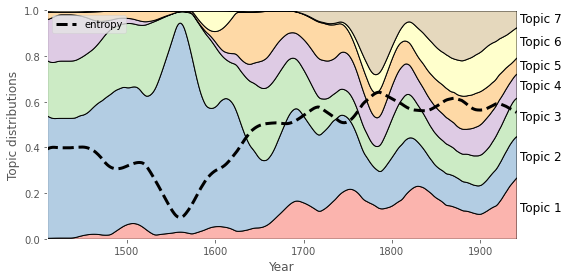

In [84]:
colors = sns.color_palette("Pastel1", 7)

for ws in window_sizes:

    fig, ax = plt.subplots(figsize=(8,4), sharex=True)

    # stacked
    x = piece_topic_freqs_all_years.index
    y = piece_topic_freqs_all_years.fillna(0).T.rolling(ws, axis=1, win_type=win_type, center=center).mean().values # fillna because of potential underflow

    ax.stackplot(
        x, 
        y, 
#         labels=[f'Topic {k}' for k in range(K)], 
        edgecolor="k",
        lw=1,
        colors=colors
#         alpha=.5, 
#         colors=categorical_palette
    )
    ax.set_ylabel('Topic distributions')
    
    ys = y[:,-1].cumsum() - y[:,-1] / 2
    
    for x, y, s in zip([1945]*7, ys, [ f"Topic {k+1}" for k in range(K)]):
        ax.text(x,y,s, va="center", fontsize=12)
    
    normalized_entropy.rolling(ws, win_type=win_type, center=center).mean()[ws:].plot(
        ax=ax, 
        c='k', 
        lw=3,
        ls="--",
        label='entropy')
    
    plt.legend(loc=2)
    plt.margins(0,0)
    plt.xlabel('Year')
    plt.tight_layout()
    
    plt.savefig(f'img/{K}_topics_evolution_new.png', dpi=300)
    plt.show()